<a href="https://colab.research.google.com/github/musicjae/NLP/blob/master/Bert/Bert_Sentiment_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [225]:
from IPython.display import Image

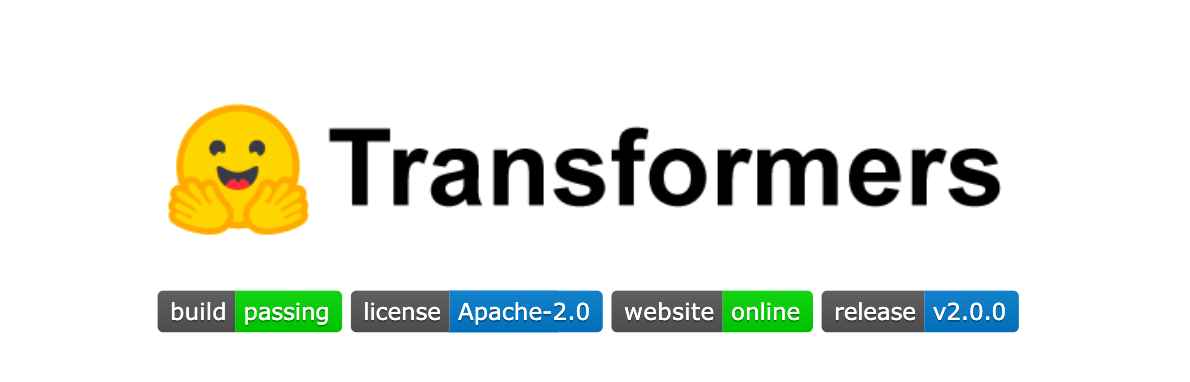

In [229]:
Image('/content/1_tAh0R8C8e9EHg3pBuBGoPQ.png',width=600)

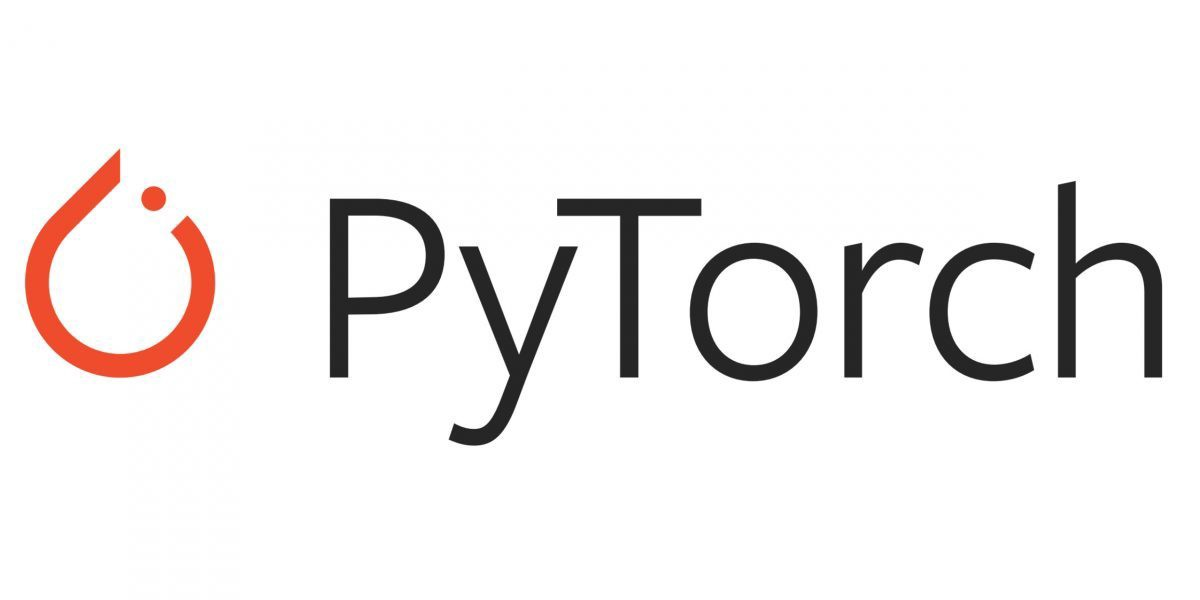

In [231]:
Image('/content/1_4br4WmxNo0jkcsY796jGDQ.jpeg',width=500)

- Huggingface  
- Pytorch  
- CoLA Dataset

**원문과 다른 점:**  
- 트레이닝 시에 나타나는 버그 수정  
- huggingface 라이브러리에서 찾을 법한 것들을 미리 찾아서 설명 추가  
- 코드 해설
  
**요구되는 개선 사항**
- 오버피팅이 나타날 수 있음

# Task: 버트로 문장 감성 분석 

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
!pip install transformers

     |████████████████████████████████| 1.4MB 24.3MB/s 
     |████████████████████████████████| 890kB 49.4MB/s 
     |████████████████████████████████| 2.9MB 25.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=62ba59fb7ad7457f29eb5c12a47718928f6400d59ca1bb6051a5d07d3e6e526d
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


wget: web -> colab 

In [ ]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9681 sha256=5b9b7d34b33a580c87c4fda12b092641c29dbb46dac3dbab963c4d544603af63
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [ ]:
import wget
import os

print('Downloading dataset...')

# The URL for the dataset zip file.
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

# Download the file (if we haven't already)
if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')

In [ ]:
# Unzip the dataset (if we haven't already)
if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

Archive:  cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_public/raw/out_of_domain_dev.tsv  


# Data Load & Preprocessing

-  The Corpus of Linguistic Acceptability (CoLA) dataset for single sentence classification.

In [ ]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(3)

Number of training sentences: 8,551



,sentence_source,label,label_notes,sentence
7480,sks13,1,NaN,John did not like Mary.
4395,ks08,0,*,Mary not avoided Bill.
6637,m_02,0,*,Into Jeeves sauntered the room.


In [ ]:
print(df.sentence[1])
print(len(df.label_notes))

One more pseudo generalization and I'm giving up.
8551


모델 학습 시, sentences, labels만 필요하다. 아래 같이 이들을 선택하자.

In [ ]:
sentences = df.sentence.values
labels = df.label.values
print(sentences[1])
print(labels[1])

One more pseudo generalization and I'm giving up.
1


## 토큰화

- do_lower_case (bool, optional, defaults to True) : Whether or not to lowercase the input when tokenizing.

- tokenizing for wordpiece embedding

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case = True)


#### 예시

In [ ]:
ex = 'I want to play the game'
tokenizer.tokenize(ex)

['i', 'want', 'to', 'play', 'the', 'game']

In [ ]:
print(sentences[21])
print(tokenizer.tokenize(sentences[21]))
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[21])))
print(labels[21])

We yelled ourselves hoarse.
['we', 'yelled', 'ourselves', 'hoarse', '.']
[2057, 7581, 9731, 21221, 1012]
1


## 전처리

- 1. CLS, SEP 붙이기  
- 2. Padding  
- 3. Vanila token과 'attention mask'가 있는 패딩 token 차이두기

 - 데이터셋에는 여러 길이의 문장들이 있다. 버트 모델에게 이것을 처리할 수 있게 하기 위해, max_len을 설정한 뒤 패딩 처리를 한다.  
 -  Attention Mask는 1, 0로 이루어진 배열이고, 이것은 토큰이 패딩임과 패딩이 아님을 뜻한다. 이 Mask는 버트 메커니즘에서 "셀프어텐션"이 PAD 토큰을 문장의 해석에 포함시키지 않음을 뜻한다.

### 문장 최대 길이 구하기

In [ ]:
max_len = 0
for sen in sentences:
    input_ids = tokenizer.encode(sen, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))

print('가장 긴 문장 길이:',max_len)

가장 긴 문장 길이: 47


### 패딩, CLS/SEP 첨가, 마스킹

- return_tensors (str or TensorType, optional) –

    - If set, will return tensors instead of list of python integers. Acceptable values are:

    - 'tf': Return TensorFlow tf.constant objects.

    - 'pt': Return PyTorch torch.Tensor objects.

    - 'np': Return Numpy np.ndarray objects.  
      
https://huggingface.co/transformers/main_classes/tokenizer.html

In [ ]:
input_ids = []
attention_masks = []

"""
문장집합 내의 각 문장에 대하여, 패딩+CLS/SEP첨가+마스킹 작업을 해준다.
"""
for sen in sentences:
    encoded_sen = tokenizer.encode_plus(sen,add_special_tokens=True,max_length=50,return_attention_mask=True,return_tensors='pt', pad_to_max_length = True) # 'pt' = pytorch's tensor
    input_ids.append(encoded_sen['input_ids']) # 이 같이 입력 아이디를 특정하지 않으면, token_type_ids, attn_mask도 출력된다.
    attention_masks.append(encoded_sen['attention_mask']) 
    """
    9, 10번 출력 예:
    'input_ids': tensor([[  101,  2028,  2062, 18404,  2236,  3989,  1998,  1045,  1005,  1049,
          3228,  2039,  1012,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]

     'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]] 

    """
print(len(input_ids))
print(len(attention_masks))    

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


8551
8551


In [ ]:
input_ids[0]

tensor([[  101,  2256,  2814,  2180,  1005,  1056,  4965,  2023,  4106,  1010,
          2292,  2894,  1996,  2279,  2028,  2057, 16599,  1012,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]])

In [ ]:
input_ids = torch.cat(input_ids,dim=0)
print(len(input_ids))
attention_masks = torch.cat(attention_masks, dim=0)
print(len(labels))
labels = torch.tensor(labels)
print(input_ids[0])

8551
8551
tensor([  101,  2256,  2814,  2180,  1005,  1056,  4965,  2023,  4106,  1010,
         2292,  2894,  1996,  2279,  2028,  2057, 16599,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


## 학습셋, 검증셋 분리

- TensorDataset은 인코딩된 문장집합을 (입력 문장 개수, 최대 문장 개수) 사이즈로 데이터셋을 만들어준다.

In [ ]:
from torch.utils.data import TensorDataset, random_split

#dataset = TensorDataset(input_ids, labels)
#dataset.tensors[0].size()

torch.Size([8551, 50])

실제 사용할 코드는 아래의 것이다. 여기서 우리는 어텐션 마스킹도 첨가한다.

In [ ]:
dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.8*len(dataset))
val_size = len(dataset)-train_size

train_dataset, val_dataset = random_split(dataset,[train_size,val_size])

print(f'학습셋 크기: {train_size}   검증셋 크기: {val_size}')

학습셋 크기: 6840   검증셋 크기: 1711


- DataLoader: 데이터셋을 배치 단위로 만들어줘서 모델이 학습하기에 용이하게 해준다.  
- RandomSampler: 데이터로더가 배치를 랜덤하게 선택하게 해준다.  
- SequentialSampler: 데이터로더가 배치를 연속적으로 선택하게 해준다.

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = BATCH_SIZE)
valid_loader = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset), batch_size = BATCH_SIZE)

데이터로더 안에 들어있는 것

In [ ]:
print(type(train_loader.dataset.dataset.tensors))
print(len(train_loader.dataset.dataset.tensors))
print(train_loader.batch_size)
print(train_loader.dataset.dataset.tensors[0].size())
print(train_loader.dataset.dataset.tensors[1].size())
print(train_loader.dataset.dataset.tensors[2].size())

<class 'tuple'>
3
16
torch.Size([8551, 50])
torch.Size([8551, 50])
torch.Size([8551])


# 모델

- AdamW에 대한 설명: https://hiddenbeginner.github.io/deeplearning/paperreview/2019/12/29/paper_review_AdamW.html

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", 
                                                      num_labels = 2, # 우리는 문장을 긍부정으로 나누는 이진 분류를 수행
                                                      output_attentions = False,
                                                      output_hidden_states = False)

model.cuda() # 모델을 GPU로 돌리게 함

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

# 훈련

**Bert 원문에서 저자가 미세 조정fine-tuning 시 추천하는 값들**

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4  
    - 우리는 차례로 16, 2e-5, 3를 선택

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8) # eps는 0으로 나누는 오류를 피하기 위해 사용

스케줄러 관한 자료: https://www.python2.net/questions-699125.html

In [ ]:
from transformers import get_linear_schedule_with_warmup

EPOCHS = 3
total_steps = len(train_loader)*EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer,num_training_steps=EPOCHS,num_warmup_steps=0) # num_warmup_steps는 디폴트값. 즉 2 개의 에폭을 돌리기 위해 따로 워밍업은 안하겠다.

In [ ]:
import random
import numpy as np

seed_val = 2020

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
steps = []
losses = []


for epoch in range(0, EPOCHS):

    total_train_loss = 0 # 매 에폭마다 초기화
    model.train() # mode train

    for step, batch in enumerate(train_loader):

        if step % 10 ==0 & step != 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_loader)))

        """
        위에서 확인했듯이, train_loader는 3 개의 원소로 구성된 튜플이다.
        이것은 각각 
        
        train_loader[0] = input_ids
        train_loader[1] = attention_mask
        train_loader[2] = labels
        를 담고 있다.
        """

        batch_input_ids = batch[0].to(device) # gpu로 돌리려고
        batch_input_mask = batch[1].to(device)
        batch_labels = batch[2].to(device)

        model.zero_grad()
        # 아래 모델의 결과는 (loss, logits)의 튜플 형식
        result = model(batch_input_ids,
              token_type_ids = None, # Segment token indices to indicate first and second portions of the inputs. Indices are selected in [0, 1]
              attention_mask = batch_input_mask,
              labels = batch_labels) # 모델 설명: https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification 

        # 위 모델에 담은 것들은 우리가 dataset에서 담은 것들이다: dataset = TensorDataset(input_ids, attention_masks, labels)
        loss, logits = result[0], result[1]
        total_train_loss += loss.item()
        
        losses.append(loss.item())
        steps.append(step)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.0) # grad explosion 방지 (optional)
        optimizer.step()

        # 스케줄러 업데이트
        scheduler.step()
        if step % 10 ==0:
            print(f'step: {step}    loss: {round(loss.item(),4)}')
    avg_training_loss = total_train_loss/len(train_loader)

    training_stats.append({
        'epoch': epoch + 1,
        'Training Loss': avg_training_loss})

    print(f'\n============avg_training_loss:  {avg_training_loss}============\n')

print('학습 끝 ^^')

step: 0    loss: 0.4807
step: 10    loss: 0.6652
step: 20    loss: 0.6378
step: 30    loss: 0.5498
step: 40    loss: 0.6081
step: 50    loss: 0.6596
step: 60    loss: 0.6293
step: 70    loss: 0.649
step: 80    loss: 0.5996
step: 90    loss: 0.646
step: 100    loss: 0.5586
step: 110    loss: 0.6912
step: 120    loss: 0.5785
step: 130    loss: 0.7614
step: 140    loss: 0.5319
step: 150    loss: 0.5909
step: 160    loss: 0.4997
step: 170    loss: 0.7436
step: 180    loss: 0.7286
step: 190    loss: 0.6702
step: 200    loss: 0.5976
step: 210    loss: 0.5115
step: 220    loss: 0.5981
step: 230    loss: 0.6566
step: 240    loss: 0.6243
step: 250    loss: 0.4582
step: 260    loss: 0.6176
step: 270    loss: 0.5589
step: 280    loss: 0.5239
step: 290    loss: 0.5388
step: 300    loss: 0.5915
step: 310    loss: 0.6219
step: 320    loss: 0.6459
step: 330    loss: 0.5204
step: 340    loss: 0.6747
step: 350    loss: 0.7407
step: 360    loss: 0.5706
step: 370    loss: 0.5459
step: 380    loss: 0.7281

# 검증

검증에 앞서, 정확도를 구하는 함수를 짜보자

In [ ]:
def flat_acc(preds,labels):
    pred_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) // len(labels_flat)

In [ ]:
model.eval()

total_eval_acc = 0
total_eval_loss = 0
val_losses = []
total_val_steps = 0
val_steps = []

for epoch in range(0,EPOCHS):
    cnt = 0
    for batch in valid_loader:
        """
        val_loader[0] = input_ids
        val_loader[1] = attention_mask
        val_loader[2] = labels
        """
        batch_val_ids = batch[0].to(device)
        batch_val_mask = batch[1].to(device)
        batch_labels = batch[2].to(device)

        with torch.no_grad(): # torch.no_grad()로 감싸는 이유는 가중치들이 requires_grad=True이지만 autograd에서는 이를 추적할 필요가 없기 때문이다.
            result = model(batch_val_ids,
                           token_type_ids = None,
                           attention_mask = batch_val_mask, 
                           labels = batch_labels)
            loss, logits = result[0], result[1]

        total_eval_loss += loss.item()
        val_losses.append(loss.item())
        val_steps.append(cnt)
        cnt += 1
        

        # 출력을 위해 텐서를 cpu의 넘파이로 옮김
        logits = logits.detach().cpu().numpy()
        label_ids = batch_labels.to('cpu').numpy()

        total_eval_acc += flat_acc(logits, label_ids)
    
    avg_eval_loss = total_eval_loss / len(valid_loader)
    avg_eval_acc = total_eval_acc / len(valid_loader)
    print(f'\n============평균 검증 정확도:  {avg_eval_acc}============\n')
    print(f'\n============평균 검증 손실:  {avg_eval_loss}============\n')

    training_stats.append({
        'Val_loss':avg_eval_loss,
        'Val_acc':avg_eval_acc
    })

print('검증도 끝 ^^')



============평균 검증 정확도:  0.009345794392523364============


============평균 검증 손실:  0.6172799381697289============


============평균 검증 정확도:  0.018691588785046728============


============평균 검증 손실:  1.2345598763394579============


============평균 검증 정확도:  0.028037383177570093============


============평균 검증 손실:  1.8518398145091868============

검증도 끝 ^^


# 결과

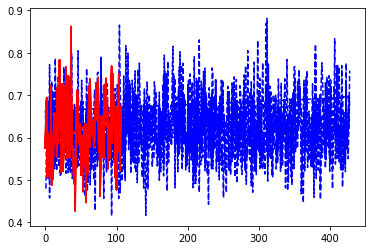

In [ ]:
import matplotlib.pyplot as plt

plt.plot(steps,losses,'b--')
plt.plot(val_steps,val_losses,'r-')
plt.show()

# 테스트

- 따로 준비해둔 516 개의 문장으로 구성된 테스트셋

In [ ]:
import pandas as pd

df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
print('Number of test sentences: {:,}\n'.format(df.shape[0]))
print(df.columns)
print(df.sentence[1])

Number of test sentences: 516

Index(['sentence_source', 'label', 'label_notes', 'sentence'], dtype='object')
They claimed they had settled on something, but it wasn't clear what they had settled on.


앞에서 했던 전처리를 여기서도 동일하게 수행

In [ ]:
sentences = df.sentence.values
labels = df.label.values

input_ids = []
attention_masks = []

for sen in sentences:
    encoded_sen = tokenizer.encode_plus(sen,
                                        add_special_tokens = True,
                                        max_length=64,
                                        return_attention_mask=True,
                                        pad_to_max_length=True,
                                        return_tensors = 'pt')
    input_ids.append(encoded_sen['input_ids'])
    attention_masks.append(encoded_sen['attention_mask'])

#list->tensor
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

BATCH_SIZE = 32

pred_data = TensorDataset(input_ids,attention_masks,labels)
pred_sampler = SequentialSampler(pred_data)
pred_loader = DataLoader(pred_data,
                         sampler=pred_sampler,
                         batch_size=BATCH_SIZE)


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
model.eval()

predictions=[]
labels =[]

for batch in pred_loader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        result = model(b_input_ids, 
                       token_type_ids = None, 
                       attention_mask = b_input_mask)
    logits = result[0]
    
    #gpu->cpu
    logits = logits.detach().cpu().numpy()
    labels_ids = b_labels.to('cpu').numpy()

    predictions.append(logits)
    labels.append(labels_ids)

print('테스트 완료 ^^')
print(len(logits),len(labels),len(predictions))
print(predictions[1])
print(labels[1])
print(len(predictions[1]))
print(len(labels[1]))

테스트 완료 ^^
4 17 17
[[-5.22860140e-02  9.42214429e-01]
 [ 1.58029467e-01  4.92303431e-01]
 [ 3.89743745e-02  9.97587860e-01]
 [ 1.23240151e-01  6.33725524e-01]
 [ 1.12563595e-01  6.45310462e-01]
 [ 1.25449568e-01  7.47154891e-01]
 [ 3.11109442e-02  8.56492281e-01]
 [-1.29896194e-01  7.45413423e-01]
 [-4.34066961e-03  9.45772171e-01]
 [ 1.88685376e-02  9.40793931e-01]
 [ 5.04645333e-02  7.78768241e-01]
 [ 1.50537819e-01  6.19503260e-01]
 [ 7.23662004e-02  9.31154668e-01]
 [-3.77127677e-02  7.06097841e-01]
 [-1.70071684e-02  6.94440007e-01]
 [ 2.57898960e-02  6.51734233e-01]
 [-5.68646826e-02  5.02504230e-01]
 [ 5.28035127e-02  9.59193170e-01]
 [-6.93192780e-02  6.73806310e-01]
 [-5.65236248e-02  6.88705385e-01]
 [-4.40158188e-01 -3.36946100e-02]
 [-3.25605795e-02  7.45551944e-01]
 [ 6.89027607e-02  8.03788602e-01]
 [ 1.61556393e-01  1.08336437e+00]
 [-1.07564649e-03  8.67509246e-01]
 [-1.07564649e-03  8.67509246e-01]
 [ 8.10913295e-02  7.74565995e-01]
 [-3.94226471e-03  8.23304415e-01]
 [

In [ ]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 354 of 516 (68.60%)


In [ ]:
label_result=[]
for lb in labels:
    label_result.append(np.sum(lb,axis=0))
print(label_result)

[19, 22, 19, 23, 21, 19, 20, 28, 24, 17, 23, 24, 19, 26, 26, 21, 3]


### 테스트 측정 결과  
  
- MCC 설명 https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html

In [ ]:
prediction_set = []
print('예측 벡터\n')
for pred in predictions:
    suma = np.sum(pred,axis=0)
    prediction_set.append(suma)
print(prediction_set)

prediction_set2 = []
for p in prediction_set:
    prediction_set2.append(p[1])
print(prediction_set2)    

result=[]
for i in range(17):
    if prediction_set2[i] - label_result[i] >4: # 4는 내가 임의로 정한 것
        result.append(0)
    elif prediction_set2[i] - label_result[i] <4:
        result.append(1)

one=0
zero=0
for j in result:
    if j == 1:
        one+=1
    else:
        zero+=1

print(one,zero)
print('accuracy: ',round((one/(one+zero))*100,3),'%')


예측 벡터

[array([ 0.4662616, 22.678963 ], dtype=float32), array([ 0.28620893, 24.375107  ], dtype=float32), array([ 1.275849, 21.919443], dtype=float32), array([ 1.0069468, 25.400478 ], dtype=float32), array([ 1.6942196, 26.534948 ], dtype=float32), array([ 0.7965374, 20.480465 ], dtype=float32), array([ 0.58308345, 22.063683  ], dtype=float32), array([ 1.5024811, 21.08399  ], dtype=float32), array([ 0.9781708, 21.15051  ], dtype=float32), array([ 1.9375188, 20.220636 ], dtype=float32), array([ 1.8616086, 20.06676  ], dtype=float32), array([ 1.9093299, 21.456003 ], dtype=float32), array([ 0.9133444, 22.061832 ], dtype=float32), array([ 1.8105123, 21.255209 ], dtype=float32), array([ 0.68716323, 22.898623  ], dtype=float32), array([ 1.0431023, 24.077984 ], dtype=float32), array([0.35804784, 3.2558308 ], dtype=float32)]
[22.678963, 24.375107, 21.919443, 25.400478, 26.534948, 20.480465, 22.063683, 21.08399, 21.15051, 20.220636, 20.06676, 21.456003, 22.061832, 21.255209, 22.898623, 24.077984

# References & Copy
  
[1] https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX#scrollTo=EKOTlwcmxmej  
[2] https://mccormickml.com/2019/07/22/BERT-fine-tuning/  
[3] https://huggingface.co/transformers/main_classes/tokenizer.html  
[4] https://hiddenbeginner.github.io/deeplearning/paperreview/2019/12/29/paper_review_AdamW.html
